# Regressing Litter on Deprivation in Glasgow City

This notebook performs data manipulation, exploration and analysis using count data regression models.

The objective is to determine whether one or more deprivation factors significantly increases or decreases the amount of litter in areas of Glasgow City.

## Data Preparation

- Read the data from a CSV file.
- Remove unnecessary columns.
- Assign valid data types.
- Impute missing values denoted by "*" with their mean.
- Impute missing values denoted by 0 with their mean.
- Split the data into training (70%), validation (20%) and test (10%) data sets.

In [22]:
import pandas as pd
import numpy as np

# Specify a random number seed so that the results are reproducable.
np.random.seed(2022)

# The path to the file containing the deprivation and litter data.
data_fpath = "../data/glasgow-simd2020v2-extended.csv"

def remove_features(df):
  """Remove features from the data that we do not need"""
  columns_to_remove = [
    #"Total_population",
    #"Working_Age_population",
    "SIMD2020v2_Rank",
    "SIMD_2020v2_Percentile",
    "SIMD2020v2_Vigintile",
    "SIMD2020v2_Decile",
    "SIMD2020v2_Quintile",
    "SIMD2020v2_Income_Domain_Rank",
    "SIMD2020_Employment_Domain_Rank",
    "SIMD2020_Health_Domain_Rank",
    "SIMD2020_Education_Domain_Rank",
    "SIMD2020_Access_Domain_Rank",
    "SIMD2020_Crime_Domain_Rank",
    "SIMD2020_Housing_Domain_Rank"
  ]
  return df.drop(columns_to_remove, axis=1)

def impute_missing_data(df):
  """Replace missing values with their mean"""
  features = [
    "Total_population",
    "Working_Age_population",
    "CIF",
    "ALCOHOL",
    "DRUG",
    "SMR",
    "DEPRESS",
    "LBWT",
    "EMERG",
    "Attendance",
    "Attainment",
    "not_participating",
    "University",
    "crime_count",
    "crime_rate",
    "broadband"
  ]
  for f in features:
    df[f].fillna(df[f].mean(), inplace=True)
    df[f].replace(to_replace=0, value=df[f].mean(), inplace=True)
  return df

def impute_data_zones(df):
  """Impute missing values from data zone S01010206 using the zone next to it."""
  features = [
    "Total_population",
    "Working_Age_population",
    "income_rate",
    "income_count",
    "employment_rate",
    "employment_count"
  ]
  for f in features:
    dz1, dz2 = df.loc[df["Data_Zone"] == "S01010206"], df.loc[df["Data_Zone"] == "S01010207"]
    n = df.at[dz2.index[0], f]
    df.at[dz1.index[0], f] = n
  return df

def convert_float_feature_types(df):
  """Convert percentage strings to floats between 0-1"""
  to_float_features = [
    "income_rate",
    "employment_rate",
    "DEPRESS",
    "LBWT",
    "Attendance",
    "not_participating",
    "University",
    "overcrowded_rate",
    "nocentralheating_rate",
    "broadband"
  ]
  # These are not percentages
  df["crime_rate"] = df["crime_rate"].astype(float)
  df["crime_count"] = df["crime_count"].astype(float)
  df["Attainment"] = df["Attainment"].astype(float)
  for f in to_float_features:
    df[f] = df[f].str.rstrip("%").astype(float) / 100
  return df

def standardise_features(df):
  features = [
    "Total_population",
    "Working_Age_population",
    "income_rate",
    "income_count",
    "employment_rate",
    "employment_count",
    "CIF",
    "ALCOHOL",
    "DRUG",
    "SMR",
    "DEPRESS",
    "LBWT",
    "EMERG",
    "Attendance",
    "Attainment",
    "no_qualifications",
    "not_participating",
    "University",
    "drive_petrol",
    "drive_GP",
    "drive_post",
    "drive_primary",
    "drive_retail",
    "drive_secondary",
    "PT_GP",
    "PT_post",
    "PT_retail",
    "broadband",
    "crime_rate",
    "crime_count",
    "overcrowded_count",
    "overcrowded_rate",
    "nocentralheating_count",
    "nocentralheating_rate"
  ]
  sdf = df[features]
  df[features] = (sdf - sdf.mean()) / sdf.std()
  return df

def convert_categorical_feature_types(df):
  """Convert strings to categorical features"""
  to_category_features = [
    "Data_Zone",
    "Intermediate_Zone",
    "Council_area"
  ]
  for f in to_category_features:
    df[f] = df[f].astype("category")
  return df

def convert_feature_types(df):
  """Convert features to the correct types"""
  df = df.replace("*", np.NaN)
  df = convert_float_feature_types(df)
  return convert_categorical_feature_types(df)

def read_data(fpath=data_fpath):
  """Read the data from file, handle missing data and assign feature types"""
  df = pd.read_csv(fpath, header=0)
  df = remove_features(df)
  df = convert_feature_types(df)
  df = impute_missing_data(df)
  return df

View how many observations we have in each data set:

In [23]:
df = read_data()
print("There are {} observations".format(len(df)))

There are 746 observations


Verify that the factor data types are correct and that there are no missing values:

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Data_Zone                746 non-null    category
 1   Intermediate_Zone        746 non-null    category
 2   Council_area             746 non-null    category
 3   Total_population         746 non-null    float64 
 4   Working_Age_population   746 non-null    float64 
 5   income_rate              746 non-null    float64 
 6   income_count             746 non-null    int64   
 7   employment_rate          746 non-null    float64 
 8   employment_count         746 non-null    int64   
 9   CIF                      746 non-null    float64 
 10  ALCOHOL                  746 non-null    float64 
 11  DRUG                     746 non-null    float64 
 12  SMR                      746 non-null    float64 
 13  DEPRESS                  746 non-null    float64 
 14  LBWT      

In [25]:
df.isnull().sum()

Data_Zone                  0
Intermediate_Zone          0
Council_area               0
Total_population           0
Working_Age_population     0
income_rate                0
income_count               0
employment_rate            0
employment_count           0
CIF                        0
ALCOHOL                    0
DRUG                       0
SMR                        0
DEPRESS                    0
LBWT                       0
EMERG                      0
Attendance                 0
Attainment                 0
no_qualifications          0
not_participating          0
University                 0
crime_count                0
crime_rate                 0
overcrowded_count          0
nocentralheating_count     0
overcrowded_rate           0
nocentralheating_rate      0
drive_petrol               0
drive_GP                   0
drive_post                 0
drive_primary              0
drive_retail               0
drive_secondary            0
PT_GP                      0
PT_post       

## Data Exploration

- Total population ranges between 260 - 2544 per data zone.
- Working age population ranges between 161 - 2361 per data zone.
- On average, 19.7% are income deprived.
- On average, 14.2% are employment deprived.
- On average, 21.1% are prescribed drugs for anxiety, depression or psychosis.
- On average, 6.9% of births are live singleton or low weight.
- On average, there is a 76.4% pupil attendance at school.
- On average, the attainment score of school leavers is 5.4.
- On average, 5.1% of 16 - 19 year olds are not in education, employment or training.
- On average, 8.8% of 17 - 21 year olds are entering university.
- On average, the comparative illness factor ratio is 152.5 (100 is Scottish average.)
- On average, the standardised mortality ratio is 124.5 (100 is Scottish average.)
- On average, the hospital stays related to alcohol misuse ratio is 176.2 (100 is Scottish average.)
- On average, the hospital stays related to drug misuse ratio is 173.1 (100 is Scottish average.)
- On average, the emergency hospital stays ratio is 122 (100 is Scottish average.)
- On average, the working age population with no qualifications ratio is 149.8 (100 is Scottish average.)
- On average, it's a 3.1 minute drive to a petrol station.
- On average, it's a 2.3 minute drive to a GP.
- On average, it's a 7.1 minute journey to a GP via public transport.
- On average, it's a 2.3 minute drive to a post office.
- On average, it's a 7.1 minute journey to a post office via public transport.
- On average, it's a 2.6 minute drive to a primary school.
- On average, it's a 4.2 minute drive to a secondary school.
- On average, it's a 3.5 minute drive to a retail centre.
- On average, it's a 9.5 minute journey to a retail centre via public transport.
- On average, 2.7% of premises do not have access to superfast broadband.
- On average, there are 444 incidents of crime per 10,000 people.
- On average, 21% are in overcrowded households.
- On average, 3.2% are in households without central heating.
- Litter ranges between 0 - 58 per data zone.
- The number of public recycling facilities per data zone ranges between 0 and 11.
- On average, there are 10 littered objects per 50 images per data zone.

In [27]:
df.describe()

,Total_population,Working_Age_population,income_rate,income_count,employment_rate,employment_count,CIF,ALCOHOL,DRUG,SMR,...,drive_post,drive_primary,drive_retail,drive_secondary,PT_GP,PT_post,PT_retail,broadband,public_recycling_points,litter
count,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.00000,746.000000,746.000000,...,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000
mean,835.814208,589.372703,0.197922,160.512064,0.142386,78.249330,152.543742,176.22043,173.134686,124.565860,...,2.346497,2.630558,3.539734,4.231587,7.098030,7.079232,9.656767,0.027847,0.993298,10.360590
std,243.423104,223.192944,0.122181,104.359384,0.091223,51.953924,71.919906,142.96172,161.396019,66.555651,...,0.829226,0.889530,1.332983,1.337981,3.066340,2.520782,3.464514,0.047389,1.492247,7.513925
min,260.000000,161.000000,0.000000,0.000000,0.000000,0.000000,5.000000,4.00000,7.000000,8.000000,...,0.667906,0.979924,0.843476,1.290801,1.595565,1.831674,2.289857,0.010000,0.000000,0.000000
25%,687.250000,452.000000,0.090000,69.000000,0.060000,33.000000,95.000000,72.25000,58.000000,87.000000,...,1.732829,1.999866,2.622112,3.239094,4.859224,5.281409,7.071742,0.015538,0.000000,5.000000
50%,809.500000,553.500000,0.190000,150.500000,0.130000,69.500000,155.000000,148.00000,145.500000,115.500000,...,2.242858,2.507080,3.392009,4.081267,6.719505,6.792529,9.250142,0.015538,0.000000,9.000000
75%,939.000000,669.000000,0.290000,237.000000,0.210000,113.000000,205.000000,240.00000,227.750000,147.000000,...,2.871751,3.084471,4.388052,5.065079,8.865254,8.518213,11.827786,0.015538,2.000000,14.000000
max,2544.000000,2361.000000,0.590000,656.000000,0.470000,311.000000,370.000000,1656.00000,1575.000000,824.000000,...,5.201232,6.935962,8.521768,8.467000,21.908923,16.288734,23.645457,0.490000,11.000000,58.000000


In [28]:
df.head()

,Data_Zone,Intermediate_Zone,Council_area,Total_population,Working_Age_population,income_rate,income_count,employment_rate,employment_count,CIF,...,drive_post,drive_primary,drive_retail,drive_secondary,PT_GP,PT_post,PT_retail,broadband,public_recycling_points,litter
0,S01009758,Darnley East,Glasgow City,624.0,407.0,0.03,20,0.05,22,85.0,...,2.788880,4.274136,3.131551,4.541446,11.631112,10.250669,10.398432,0.015538,0,6
1,S01009759,Darnley East,Glasgow City,860.0,570.0,0.45,387,0.27,153,240.0,...,1.743391,2.308576,2.961266,5.923537,4.641285,5.090064,6.609695,0.015538,0,31
2,S01009760,Darnley East,Glasgow City,852.0,550.0,0.23,194,0.18,96,195.0,...,1.790476,2.941404,3.057892,5.061042,6.407102,6.119720,7.519863,0.015538,0,14
3,S01009761,Darnley East,Glasgow City,846.0,558.0,0.13,106,0.08,45,120.0,...,2.485582,3.777761,3.348901,5.016264,9.419198,8.381563,10.105440,0.015538,0,8
4,S01009762,Darnley East,Glasgow City,1183.0,801.0,0.25,299,0.13,102,165.0,...,0.879530,2.058761,3.241455,4.971114,3.151404,2.782003,7.058888,0.015538,1,34


### Correlations

The positive correlations (>= .3) are no_qualifications, income_rate, CIF, employment_rate, EMERG, DEPRESS, SMR and ALCOHOL.

The negative correlations (>= .3) are Attainment and Attendance.

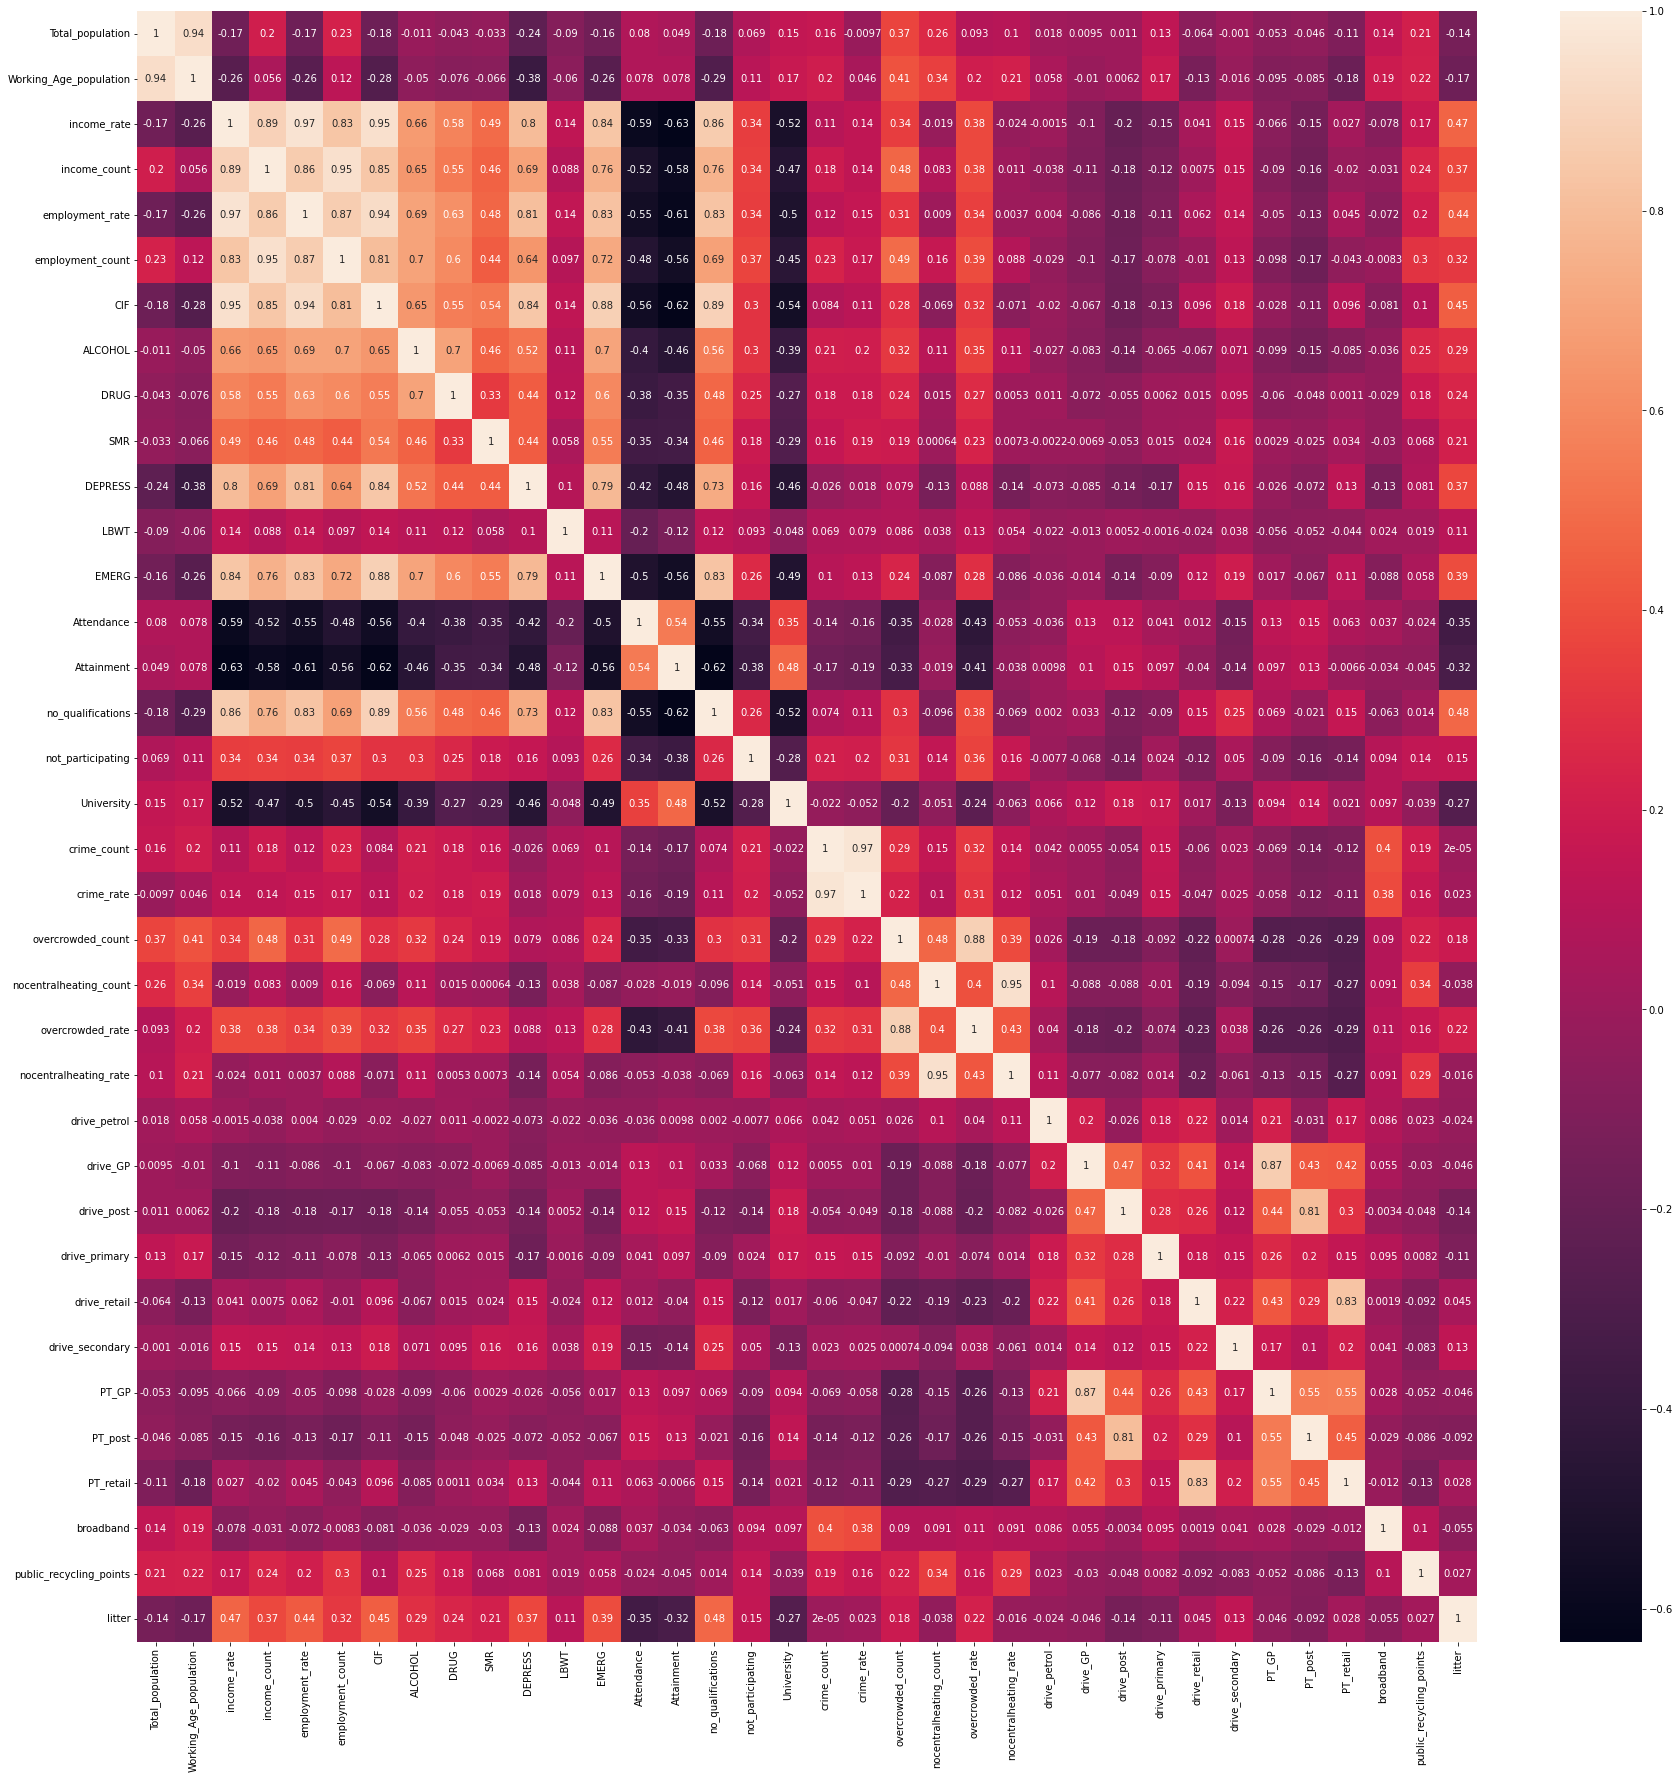

In [9]:
import seaborn as sn
import matplotlib.pyplot as plt

def plot_correlation_matrix(df, columns, figsize=(10,10)):
  plt.figure(figsize=figsize)
  corr_df = pd.DataFrame(df, columns=columns)
  sn.heatmap(corr_df.corr(), annot=True)
  plt.show()

plot_correlation_matrix(df, df.columns, figsize=(30,30))

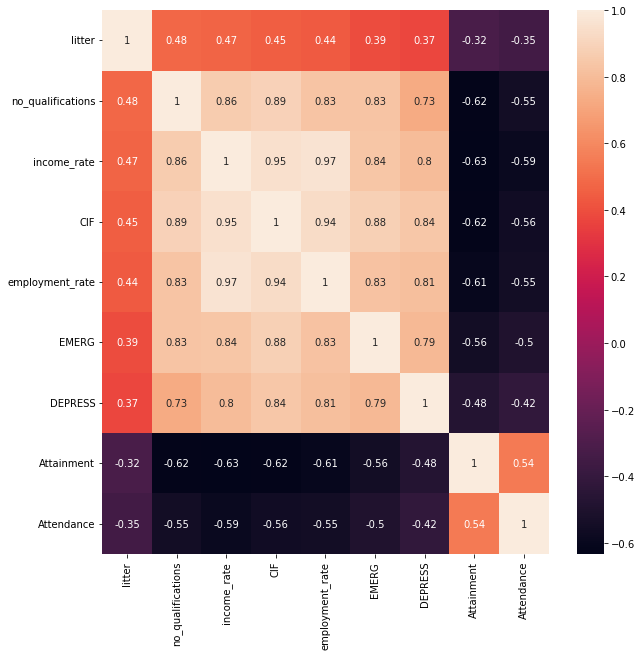

In [10]:
features_with_corr = [
  "litter",
  # Positive
  "no_qualifications",
  "income_rate",
  "CIF",
  "employment_rate",
  "EMERG",
  "DEPRESS",
  # Negative
  "Attainment",
  "Attendance"
]

plot_correlation_matrix(df, columns=features_with_corr)

## Visualise

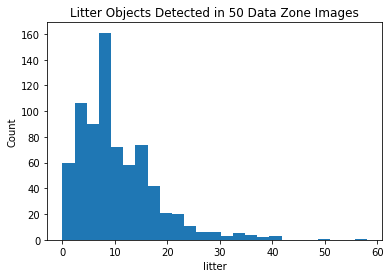

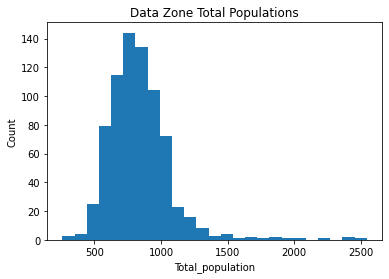

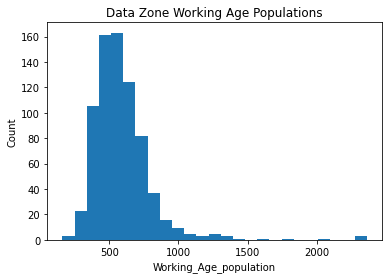

In [11]:
def plot_histogram(column, title, bins=25):
  ax = df.hist(column=column, bins=bins, grid=False)
  for x in ax[0]:
    x.set_title(title)
    x.set_xlabel(column)
    x.set_ylabel("Count")

plot_histogram("litter", title="Litter Objects Detected in 50 Data Zone Images")
plot_histogram("Total_population", title="Data Zone Total Populations")
plot_histogram("Working_Age_population", title="Data Zone Working Age Populations")

## Standardise

Standardise the predictors for regression as they are in different units.

In [12]:
df = standardise_features(df)

## Poission

Train a Poisson regression model using forward variable selection.

In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

def forward_selection(df, response, smf_model=smf.poisson, family=sm.families.Poisson()):
    remaining = set(df.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response, ' + '.join(selected + [candidate]))
            model = smf_model(formula, df).fit(method="newton")
            score = model.aic
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        print(f"current_score ({current_score}) > best_new_score ({best_new_score})")
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            print("Best new score:", best_new_score)
            print("Selected:", selected)
            print("Remaining:", remaining)
            print()
    print("Best score:", best_new_score)
    print("Selected:", selected)
    print("Remaining:", remaining)
    formula = "{} ~ {}".format(response, ' + '.join(selected))
    print("CHOSEN FORMULA: ", formula)
    y_train, X_train = dmatrices(formula, df, return_type="dataframe")
    model = sm.GLM(y_train, X_train, family=family).fit()
    return model

df_in = df[features_with_corr]
poisson_model = forward_selection(df_in, "litter")

Optimization terminated successfully.
         Current function value: 4.127455
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.026499
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.861197
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.073450
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.905248
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.017076
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.775444
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.824974
         Iterations 5
current_score (inf) > best_new_score (6162.162788036787)
Best new score: 6162.162788036787
Selected: ['Attainment']
Remaining: {'DEPRESS', 'CIF', 'Attendance', 'employment_rate', 'EMER

In [14]:
print(poisson_model.summary())
print("AIC:", poisson_model.aic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 litter   No. Observations:                  746
Model:                            GLM   Df Residuals:                      737
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2773.7
Date:                Fri, 29 Apr 2022   Deviance:                       2619.5
Time:                        08:04:32   Pearson chi2:                 2.77e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.7451
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.2712      0.01

The model does not fit as its pearson chi squared value is greater than expected.

In [15]:
from scipy.stats import chi2

def check_pearson_chi2(pearson_chi2, residuals):
  chi_sq = chi2.ppf(.05, df=residuals)
  print("Pearson Chi Sq <= Chi Sq")
  print(f"{pearson_chi2} <= {chi_sq}")
  print(f"The model fits: {pearson_chi2 <= chi_sq}")

check_pearson_chi2(pearson_chi2=poisson_model.pearson_chi2, residuals=poisson_model.df_resid)

Pearson Chi Sq <= Chi Sq
2774.269422268891 <= 675.0069166176114
The model fits: False


## Negative Binomial

Train a negative binomial regression model using forward variable selection.

In [16]:
alpha = 0.4
nb_model = forward_selection(df_in, "litter", smf_model=smf.negativebinomial, family=sm.families.NegativeBinomial(alpha=alpha))

Optimization terminated successfully.
         Current function value: 3.174315
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.156287
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.112509
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.163997
         Iterations 4
Optimization terminated successfully.
         Current function value: 3.122082
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.145940
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.087035
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.102635
         Iterations 5
current_score (inf) > best_new_score (4742.077284226923)
Best new score: 4742.077284226923
Selected: ['Attainment']
Remaining: {'DEPRESS', 'CIF', 'Attendance', 'employment_rate', 'EMER

The model does fit:

In [17]:
print(nb_model.summary())
print("AIC:", nb_model.aic)
check_pearson_chi2(pearson_chi2=nb_model.pearson_chi2, residuals=nb_model.df_resid)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 litter   No. Observations:                  746
Model:                            GLM   Df Residuals:                      737
Model Family:        NegativeBinomial   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2314.0
Date:                Fri, 29 Apr 2022   Deviance:                       555.86
Time:                        08:04:33   Pearson chi2:                     546.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2402
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.2692      0.02

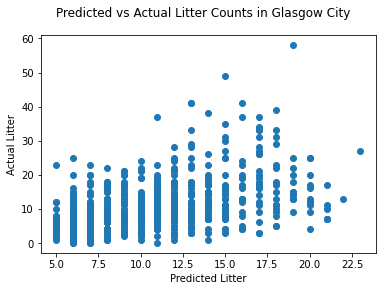

In [18]:
import matplotlib.pyplot as plt

def get_predicted_counts(model, X):
    predictions = model.get_prediction(X)
    df_predictions = predictions.summary_frame()
    return round(df_predictions["mean"])

def scatter_plot(df, formula, model):
    y, X = dmatrices(formula, df, return_type="dataframe")
    predicted_counts, actual_counts = get_predicted_counts(model, X), y["litter"]
    fig = plt.figure()
    fig.suptitle("Predicted vs Actual Litter Counts in Glasgow City")
    plt.scatter(x=predicted_counts, y=actual_counts)
    plt.xlabel("Predicted Litter")
    plt.ylabel("Actual Litter")
    plt.show()

nb_model_formula = "litter ~ Attainment + Attendance + DEPRESS + EMERG + employment_rate + CIF + income_rate + no_qualifications"
scatter_plot(df_in, nb_model_formula, nb_model)

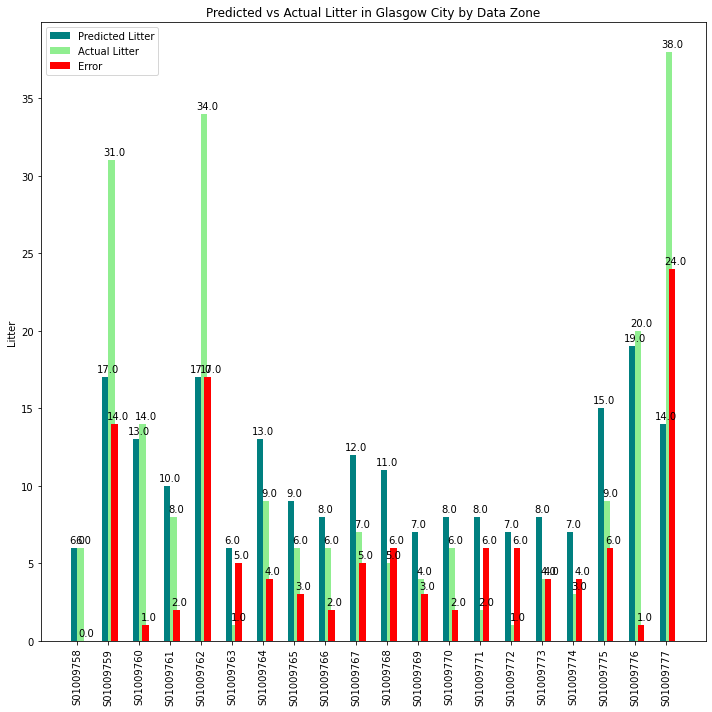

In [19]:
def bar_plot(df, formula, model, n_bars=20, bar_width=0.2):
    y, X = dmatrices(formula, df, return_type="dataframe")
    indices = X.index[:n_bars]
    labels = read_data(data_fpath).iloc[indices]["Data_Zone"]
    predicted_counts, actual_counts = get_predicted_counts(model, X), y["litter"]
    y_predicted = predicted_counts[:n_bars]
    y_actual = actual_counts[:n_bars]
    y_err = abs(y_predicted - y_actual)

    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(10)
    x = np.arange(len(labels))
    rects1 = ax.bar(x - bar_width/2, y_predicted, bar_width, label="Predicted Litter", color="teal")
    rects2 = ax.bar(x + bar_width/2, y_actual, bar_width, label="Actual Litter", color="lightgreen")
    rects3 = ax.bar(x + (bar_width/2) + (bar_width/2), y_err, bar_width, label="Error", color="red")
    ax.set_ylabel("Litter")
    ax.set_title("Predicted vs Actual Litter in Glasgow City by Data Zone")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90)
    ax.legend()
    for rects in [rects1, rects2, rects3]:
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                f"{height}",
                xy=(rect.get_x() + rect.get_width() / 2 + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center", va='bottom'
        )
    fig.tight_layout()
    plt.show()

bar_plot(df_in, nb_model_formula, nb_model)

### Bonferroni Correction

Apply Bonferroni correction to the p-values to account for significant by random chance.

In [20]:
from statsmodels.stats.multitest import multipletests
reject, corrected_pvalues, _, _ = multipletests(nb_model.pvalues, alpha=0.05, method="bonferroni")
print(nb_model.pvalues)
print(corrected_pvalues)
print(reject)

Intercept            0.000000
Attainment           0.846556
Attendance           0.073394
DEPRESS              0.507541
EMERG                0.158103
employment_rate      0.152394
CIF                  0.644959
income_rate          0.012848
no_qualifications    0.000003
dtype: float64
[0.00000000e+00 1.00000000e+00 6.60549171e-01 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.15636093e-01
 3.11383566e-05]
[ True False False False False False False False  True]
